Issues
 - beat tracking for some songs starts VERY late (up to 90 s in some cases??!)
    - Solution: use essentia, naybe? Or some fancier beat tracker. Or Spotify lookup.

In [2]:
! pip install -r requirements.txt

  Obtaining dependency information for certifi==2023.7.22 from https://files.pythonhosted.org/packages/4c/dd/2234eab22353ffc7d94e8d13177aaa050113286e93e7b40eae01fbf7c3d9/certifi-2023.7.22-py3-none-any.whl.metadata
  Using cached certifi-2023.7.22-py3-none-any.whl.metadata (2.2 kB)
  Obtaining dependency information for contourpy==1.1.0 from https://files.pythonhosted.org/packages/a4/67/ab422872caf036e95c764b25163619da59c35e34cc70c166c0250a05900e/contourpy-1.1.0-cp38-cp38-macosx_11_0_arm64.whl.metadata
  Using cached contourpy-1.1.0-cp38-cp38-macosx_11_0_arm64.whl.metadata (5.7 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Obtaining dependency information for fonttools==4.42.0 from https://files.pythonhosted.org/packages/2a/26/2ccd772ae7a771d0bb5a2b23554713b87f93001b72e88f118e8a693eb51a/fonttools-4.42.0-cp38-cp38-macosx_10_9_universal2.whl.metadata
  Using cached fonttools-4.42.0-cp38-cp38-macosx_10_9_universal2.whl.metadata (150 kB)
  Obtaining dependency information for

In [3]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import librosa
import subprocess
import os
from pydub import AudioSegment
from typing import Dict, List, Tuple

from highlight_detector import HighlightDetector
from file_recognizer import FileRecognizer
from settings import (FIELD_SONG_ID, FIELD_SONGNAME)
import networkx as nx
from typing import Tuple, List, Dict

In [4]:
def analyze_non_lyrical(input_file: str, dir: str) -> Tuple[List[float], Dict[str, List[float]], Dict[str, float], int]:
    slices_dir = dir + "slices"

    # Remove directory if it exists
    subprocess.run(["mkdir", slices_dir.split("/")[0]], check=False)
    subprocess.run(["rm", "-r", slices_dir], check=False)

    # Create directory
    subprocess.run(["mkdir", slices_dir], check=True)

    highlight_detector = HighlightDetector()

    y, sr = librosa.load(input_file, sr=None)

    # Detect beats
    # TODO: develop countermeasure when there are no beat times. 
    _, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    #avg_bpm, beat_start, confidence, tempo, beat_duration = es.RhythmExtractor2013(method='multifeature')(audio)
    song = AudioSegment.from_mp3(input_file) # load song in with pydub

    song_slices = []
    
    # sample 16-beat moments from the song and re-save them as their own slices. 
    i = 0
    while i+16 < len(beat_times):
        song_slice = song[beat_times[i]*1000:beat_times[i+16]*1000] # pydub does things in milliseconds
        song_slices.append(song_slice)
        song_slice.export(f"{slices_dir}/{beat_times[i]}_{beat_times[i+16]}.mp3", format="mp3")
        i += 16
    song_slice = song[beat_times[i]*1000:beat_times[-1]*1000]
    song_slice.export(f"{slices_dir}/{beat_times[i]}_{beat_times[-1]}.mp3", format="mp3")
    
    assert(djv.get_fingerprinted_songs()==[])

    djv.fingerprint_directory(f"{slices_dir}", [".mp3"])
    
    '''print("printing songs:")
    djv.print_df_songs()
    print("printing fingerprints:")
    djv.print_df_fingerprints()'''

    song_ids = {}
    binsize = 0
    for row in djv.get_fingerprinted_songs():
        song_id = row[FIELD_SONG_ID]
        song_name = row[FIELD_SONGNAME]
        song_ids[song_name] = song_id
        binsize += 1

    # remove every song from the database one at a time, then re-add into the dictionary.
    # the key re-added into the dictionary should be max_num + 1
    # preprocess the query string such that we can extract the starting point of the best match. 
    # keep an array of the numbers that got returned from the query
    # plot a heatmap of the timestamps that got returned. 

    timestamps = []
    timestamps_graph = {} # used to plot the a graph where each node is a timestamps, to show their relationships

    for file in os.listdir(f"{slices_dir}"): 
        song_name = file.split(".mp3")[0]
        # print(f"Current file: {song_name}")
        try:
            djv.delete_songs_by_id([song_ids[song_name]]) # delete the file from the db
        except Exception as e:
            if song_name not in song_ids:
                print(f"Song name {song_name} not found in song_id: {song_id}. Parsing must have failed.")
                return 
            print(f"{e}: Failed to delete the following file during moment processing: {song_name} song id: {song_ids[song_name]}")
            return
        results = djv.recognize(FileRecognizer, f"{slices_dir}/"+file)

        result_names = [result['song_name'] for result in results['results']]
        print(f"From file we recognized: {result_names}\n")
        timestamps_per_song = []
        for result_name in result_names:
            result_name = result_name.decode().split('_')[0]
            try:   
                timestamps.append(float(result_name))
                timestamps_per_song.append(round(float(result_name), 2))
            except ValueError as e:
                print(f"{e}")
                pass
        # create a dict where the key is the current file name in str
        timestamps_graph[round(float(file.split('_')[0]), 2)] = timestamps_per_song

        try:
            # re-add the song entry into the db
            djv.fingerprint_file(f"{slices_dir}/{file}") 
        except Exception as e:
            print(f"{e}: Failed to fingerprint the following file: {slices_dir}/{file}")

        song_ids[song_name] = djv.get_latest_song_id()
        
    with open("results.txt", "w") as f:
        f.write(str(timestamps_graph))
        f.write('\n')

    print(f"\nTimestamps of identified moments: {timestamps}")
    print(f"\nSong moments and their ids: {song_ids}")

    print("\nFile processing was succesfully completed!")
    return timestamps, timestamps_graph, song_ids, binsize

In [5]:
class Node:
    def __init__(self):
        self.value = ""
        self.leaves = []
        self.nodes = []

    def checkNodes(self, suf):
        for node in self.nodes:
            if node.value == suf[0]:
                node.addSuffix(suf[1:])
                return True
        return False

    def checkLeaves(self, suf):
        for i, leaf in enumerate(self.leaves):
            if leaf[0] == suf[0]:
                node = Node()
                node.value = leaf[0]
                node.addSuffix(suf[1:])
                node.addSuffix(leaf[1:])
                self.nodes.append(node)
                self.leaves.pop(i)
                return
        self.leaves.append(suf)

    def addSuffix(self, suf):
        if not suf:
            return
        if not self.checkNodes(suf):
            self.checkLeaves(suf)

    def getLongestRepeatedSubString(self):
        str = ""
        for node in self.nodes:
            temp = node.getLongestRepeatedSubString()
            if len(temp) > len(str):
                str = temp
        return self.value + str

    def toHTML(self):
        html = "<div class=node>"
        if self.value:
            html += "<h3>" + self.value + "</h3>"
        if self.nodes:
            html += "<h4>nodes</h4><ul>"
            for node in self.nodes:
                html += "<li>" + node.toHTML() + "</li>"
            html += "</ul>"
        if self.leaves:
            html += "<h4>leaves</h4><ul>"
            for leaf in self.leaves:
                html += "<li>" + leaf + "</li>"
            html += "</ul>"
        return html


class SuffixTree:
    def __init__(self, string):
        self.node = Node()
        for i in range(len(string)):
            self.node.addSuffix(string[i:])

In [6]:
def plot_histogram(name: str, save_dir: str, timestamps: List[float], binsize: int, df):
    # Plot the heatmap
    plt.figure(figsize=(15, 3))
    sns.heatmap(df, cmap="YlGnBu", cbar_kws={'label': 'Density'})
    plt.title(f'Timestamp Density for {name}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency')
    plt.savefig(save_dir + 'output.png')
    plt.show() 

In [ ]:
# How good should "good enough" be when deploying, and when do we start other things before deciding something is "good enough?"
    # I suppose some dataset should be used? 

mkdir: test1: File exists


From file we recognized: [b'57.461333333333336_66.272', b'228.53333333333333_237.44']

Fingerprinting channel 1/2 for test1/slices/174.53866666666667_183.49866666666668.mp3
Finished channel 1/2 for test1/slices/174.53866666666667_183.49866666666668.mp3
Fingerprinting channel 2/2 for test1/slices/174.53866666666667_183.49866666666668.mp3
Finished channel 2/2 for test1/slices/174.53866666666667_183.49866666666668.mp3
From file we recognized: [b'264.6933333333333_273.41866666666664', b'282.208_291.392']

Fingerprinting channel 1/2 for test1/slices/273.41866666666664_282.208.mp3
Finished channel 1/2 for test1/slices/273.41866666666664_282.208.mp3
Fingerprinting channel 2/2 for test1/slices/273.41866666666664_282.208.mp3
Finished channel 2/2 for test1/slices/273.41866666666664_282.208.mp3
From file we recognized: [b'39.53066666666667_48.49066666666667', b'228.53333333333333_237.44']

Fingerprinting channel 1/2 for test1/slices/48.49066666666667_57.461333333333336.mp3
Finished channel 1/2 fo

rm: test1/results.txt: No such file or directory


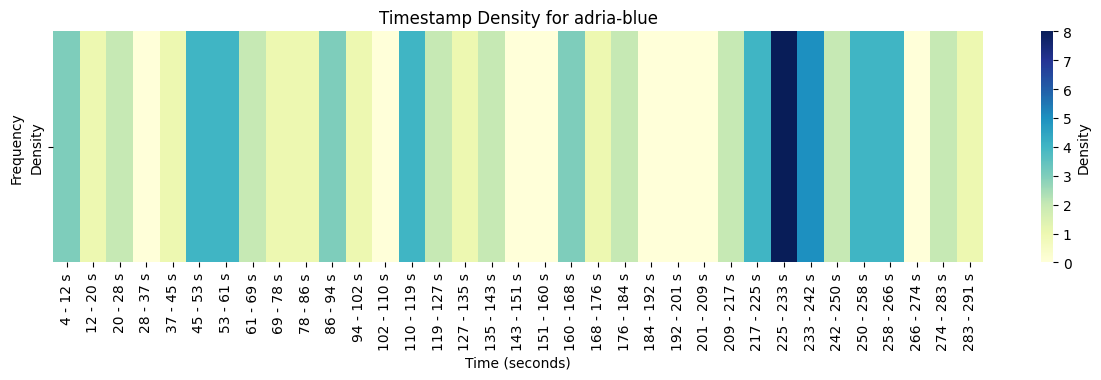

timestamps: [57.461333333333336, 228.53333333333333, 264.6933333333333, 282.208, 39.53066666666667, 228.53333333333333, 129.62133333333333, 237.44, 120.576, 219.41333333333333, 4.245333333333333, 21.856, 57.461333333333336, 174.53866666666667, 228.53333333333333, 264.6933333333333, 228.53333333333333, 75.27466666666666, 255.91466666666668, 264.6933333333333, 219.41333333333333, 228.53333333333333, 165.61066666666667, 57.461333333333336, 246.89066666666668, 48.49066666666667, 111.488, 183.49866666666668, 66.272, 48.49066666666667, 255.91466666666668, 93.42933333333333, 84.384, 111.488, 57.461333333333336, 183.49866666666668, 21.856, 138.51733333333334, 228.53333333333333, 165.61066666666667, 255.91466666666668, 246.89066666666668, 237.44, 228.53333333333333, 228.53333333333333, 291.392, 111.488, 210.51733333333334, 102.496, 138.51733333333334, 111.488, 48.49066666666667, 264.6933333333333, 282.208, 4.245333333333333, 13.301333333333334, 255.91466666666668, 165.61066666666667, 66.272, 23

mkdir: test2: File exists


From file we recognized: [b'164.8_171.44533333333334', b'130.50666666666666_137.36533333333333']

Fingerprinting channel 1/2 for test2/slices/157.94133333333335_164.8.mp3
Finished channel 1/2 for test2/slices/157.94133333333335_164.8.mp3
Fingerprinting channel 2/2 for test2/slices/157.94133333333335_164.8.mp3
Finished channel 2/2 for test2/slices/157.94133333333335_164.8.mp3
From file we recognized: [b'205.728_212.58666666666667', b'110.15466666666667_117.01333333333334']

Fingerprinting channel 1/2 for test2/slices/219.44533333333334_226.304.mp3
Finished channel 1/2 for test2/slices/219.44533333333334_226.304.mp3
Fingerprinting channel 2/2 for test2/slices/219.44533333333334_226.304.mp3
Finished channel 2/2 for test2/slices/219.44533333333334_226.304.mp3
From file we recognized: [b'233.16266666666667_240.01066666666668', b'246.656_253.728']

Fingerprinting channel 1/2 for test2/slices/301.728_308.3946666666667.mp3
Finished channel 1/2 for test2/slices/301.728_308.3946666666667.mp3
Fin

rm: test2/results.txt: No such file or directory


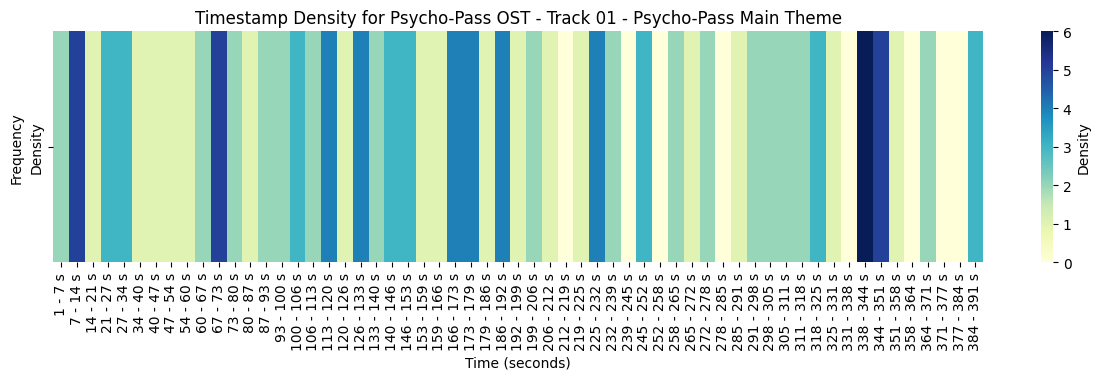

timestamps: [164.8, 130.50666666666666, 205.728, 110.15466666666667, 233.16266666666667, 246.656, 96.66133333333333, 103.296, 76.096, 342.8906666666667, 322.09066666666666, 308.3946666666667, 185.152, 198.86933333333334, 391.0933333333333, 342.8906666666667, 267.44533333333334, 274.29333333333335, 315.232, 308.3946666666667, 349.7386666666667, 69.23733333333334, 55.52, 130.50666666666666, 48.66133333333333, 349.7386666666667, 260.58666666666664, 21.44, 28.298666666666666, 21.44, 349.7386666666667, 171.44533333333334, 233.16266666666667, 130.50666666666666, 28.298666666666666, 14.645333333333333, 7.946666666666666, 342.8906666666667, 1.2906666666666666, 62.37866666666667, 89.80266666666667, 171.44533333333334, 76.096, 171.44533333333334, 246.656, 117.01333333333334, 246.656, 260.58666666666664, 117.01333333333334, 212.58666666666667, 226.304, 117.01333333333334, 62.37866666666667, 7.946666666666666, 7.946666666666666, 391.0933333333333, 69.23733333333334, 178.304, 391.0933333333333, 42.

mkdir: test3: File exists


From file we recognized: [b'87.22133333333333_96.128', b'167.22133333333332_176.10666666666665']

Fingerprinting channel 1/2 for test3/slices/176.10666666666665_184.91733333333335.mp3
Finished channel 1/2 for test3/slices/176.10666666666665_184.91733333333335.mp3
Fingerprinting channel 2/2 for test3/slices/176.10666666666665_184.91733333333335.mp3
Finished channel 2/2 for test3/slices/176.10666666666665_184.91733333333335.mp3
From file we recognized: [b'87.22133333333333_96.128', b'52.128_60.576']

Fingerprinting channel 1/2 for test3/slices/96.128_104.992.mp3
Finished channel 1/2 for test3/slices/96.128_104.992.mp3
Fingerprinting channel 2/2 for test3/slices/96.128_104.992.mp3
Finished channel 2/2 for test3/slices/96.128_104.992.mp3
From file we recognized: [b'113.888_122.70933333333333', b'78.368_87.22133333333333']

Fingerprinting channel 1/2 for test3/slices/60.576_69.45066666666666.mp3
Finished channel 1/2 for test3/slices/60.576_69.45066666666666.mp3
Fingerprinting channel 2/2 fo

rm: test3/results.txt: No such file or directory


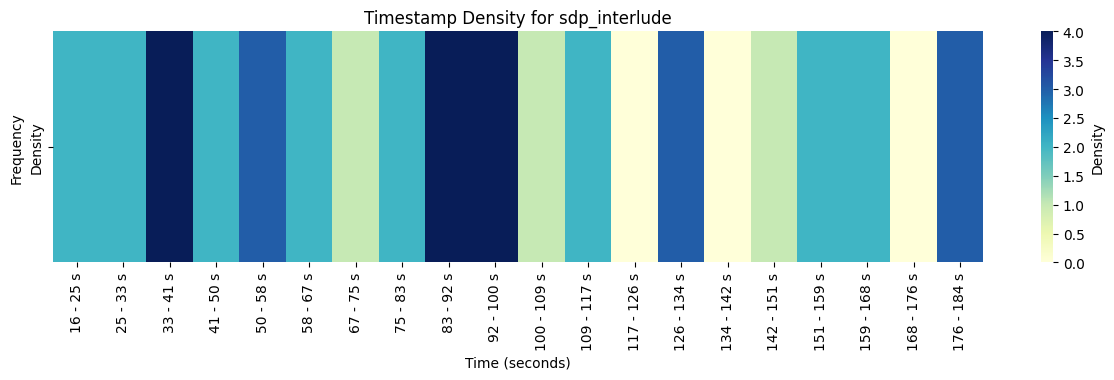

timestamps: [87.22133333333333, 167.22133333333332, 87.22133333333333, 52.128, 113.888, 78.368, 34.44266666666667, 131.66933333333333, 149.41866666666667, 167.22133333333332, 184.91733333333335, 87.22133333333333, 78.368, 60.576, 184.91733333333335, 96.128, 25.546666666666667, 60.576, 104.992, 25.546666666666667, 87.22133333333333, 96.128, 52.128, 96.128, 69.45066666666666, 34.44266666666667, 43.33866666666667, 131.66933333333333, 158.336, 96.128, 34.44266666666667, 43.33866666666667, 16.650666666666666, 52.128, 34.44266666666667, 131.66933333333333, 113.888, 16.650666666666666, 158.336, 184.91733333333335]


mkdir: test5: File exists


From file we recognized: [b'59.050666666666665_66.53866666666667', b'113.152_120.832']

Fingerprinting channel 1/2 for test5/slices/136.288_144.01066666666668.mp3
Finished channel 1/2 for test5/slices/136.288_144.01066666666668.mp3
Fingerprinting channel 2/2 for test5/slices/136.288_144.01066666666668.mp3
Finished channel 2/2 for test5/slices/136.288_144.01066666666668.mp3
From file we recognized: [b'74.37866666666666_82.19733333333333', b'82.19733333333333_89.89866666666667']

Fingerprinting channel 1/2 for test5/slices/113.152_120.832.mp3
Finished channel 1/2 for test5/slices/113.152_120.832.mp3
Fingerprinting channel 2/2 for test5/slices/113.152_120.832.mp3
Finished channel 2/2 for test5/slices/113.152_120.832.mp3
From file we recognized: [b'151.85066666666665_159.28533333333334', b'159.28533333333334_165.664']

Fingerprinting channel 1/2 for test5/slices/144.01066666666668_151.85066666666665.mp3
Finished channel 1/2 for test5/slices/144.01066666666668_151.85066666666665.mp3
Fingerp

rm: test5/results.txt: No such file or directory


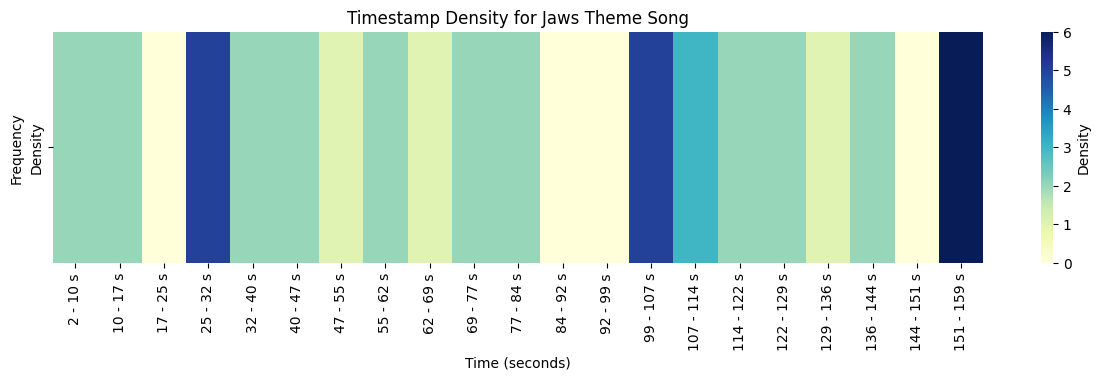

timestamps: [59.050666666666665, 113.152, 74.37866666666666, 82.19733333333333, 151.85066666666665, 159.28533333333334, 128.52266666666668, 105.38666666666667, 113.152, 159.28533333333334, 26.613333333333333, 10.954666666666666, 105.38666666666667, 34.656, 128.52266666666668, 74.37866666666666, 42.57066666666667, 26.613333333333333, 105.38666666666667, 151.85066666666665, 113.152, 105.38666666666667, 151.85066666666665, 42.57066666666667, 120.832, 66.53866666666667, 151.85066666666665, 144.01066666666668, 51.104, 136.288, 82.19733333333333, 26.613333333333333, 26.613333333333333, 10.954666666666666, 2.9013333333333335, 26.613333333333333, 2.9013333333333335, 34.656, 105.38666666666667, 144.01066666666668, 59.050666666666665, 120.832]


mkdir: test6: File exists


From file we recognized: [b'222.28266666666667_227.808', b'216.992_222.28266666666667']

Fingerprinting channel 1/2 for test6/slices/99.2_104.66133333333333.mp3
Finished channel 1/2 for test6/slices/99.2_104.66133333333333.mp3
Fingerprinting channel 2/2 for test6/slices/99.2_104.66133333333333.mp3
Finished channel 2/2 for test6/slices/99.2_104.66133333333333.mp3
From file we recognized: [b'185.28_190.57066666666665', b'46.67733333333333_51.861333333333334']

Fingerprinting channel 1/2 for test6/slices/132.07466666666667_137.45066666666668.mp3
Finished channel 1/2 for test6/slices/132.07466666666667_137.45066666666668.mp3
Fingerprinting channel 2/2 for test6/slices/132.07466666666667_137.45066666666668.mp3
Finished channel 2/2 for test6/slices/132.07466666666667_137.45066666666668.mp3
From file we recognized: [b'164.24533333333332_169.45066666666668', b'72.74666666666667_77.92']

Fingerprinting channel 1/2 for test6/slices/20.554666666666666_25.781333333333333.mp3
Finished channel 1/2 f

rm: test6/results.txt: No such file or directory


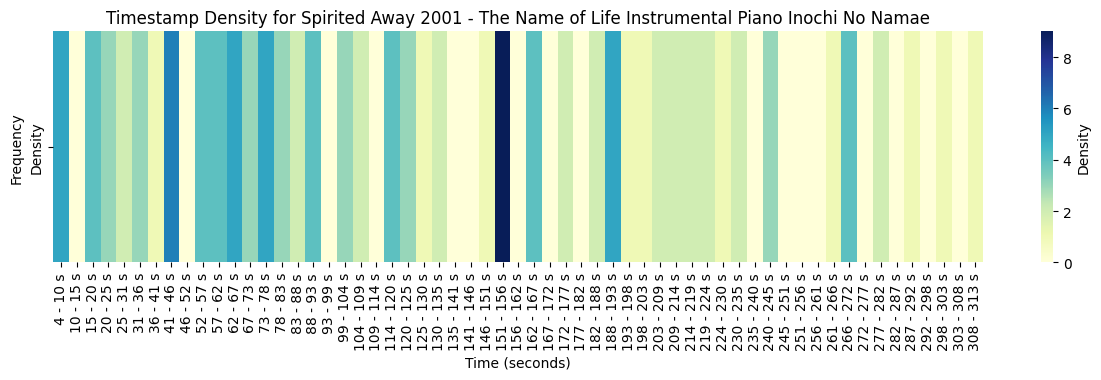

timestamps: [222.28266666666667, 216.992, 185.28, 46.67733333333333, 164.24533333333332, 72.74666666666667, 281.728, 243.81866666666667, 99.2, 104.66133333333333, 233.14133333333334, 115.648, 10.154666666666667, 153.57866666666666, 153.57866666666666, 30.997333333333334, 206.42133333333334, 93.92, 77.92, 36.202666666666666, 62.304, 20.554666666666666, 36.202666666666666, 46.67733333333333, 36.202666666666666, 153.57866666666666, 104.66133333333333, 83.28533333333333, 25.781333333333333, 132.07466666666667, 46.67733333333333, 67.53066666666666, 57.09866666666667, 62.304, 216.992, 83.28533333333333, 121.17333333333333, 190.57066666666665, 153.57866666666666, 25.781333333333333, 77.92, 211.70133333333334, 46.67733333333333, 270.848, 57.09866666666667, 46.67733333333333, 93.92, 99.2, 270.848, 281.728, 115.648, 190.57066666666665, 190.57066666666665, 62.304, 190.57066666666665, 67.53066666666666, 227.808, 222.28266666666667, 57.09866666666667, 153.57866666666666, 62.304, 67.53066666666666, 

mkdir: test7: File exists


From file we recognized: [b'26.357333333333333_33.00266666666667', b'33.00266666666667_39.57333333333333']

Fingerprinting channel 1/2 for test7/slices/0.11733333333333333_6.645333333333333.mp3
Finished channel 1/2 for test7/slices/0.11733333333333333_6.645333333333333.mp3
Fingerprinting channel 2/2 for test7/slices/0.11733333333333333_6.645333333333333.mp3
Finished channel 2/2 for test7/slices/0.11733333333333333_6.645333333333333.mp3
From file we recognized: [b'33.00266666666667_39.57333333333333', b'46.154666666666664_52.72533333333333']

Fingerprinting channel 1/2 for test7/slices/26.357333333333333_33.00266666666667.mp3
Finished channel 1/2 for test7/slices/26.357333333333333_33.00266666666667.mp3
Fingerprinting channel 2/2 for test7/slices/26.357333333333333_33.00266666666667.mp3
Finished channel 2/2 for test7/slices/26.357333333333333_33.00266666666667.mp3
From file we recognized: [b'19.797333333333334_26.357333333333333', b'46.154666666666664_52.72533333333333']

Fingerprinting

rm: test7/results.txt: No such file or directory


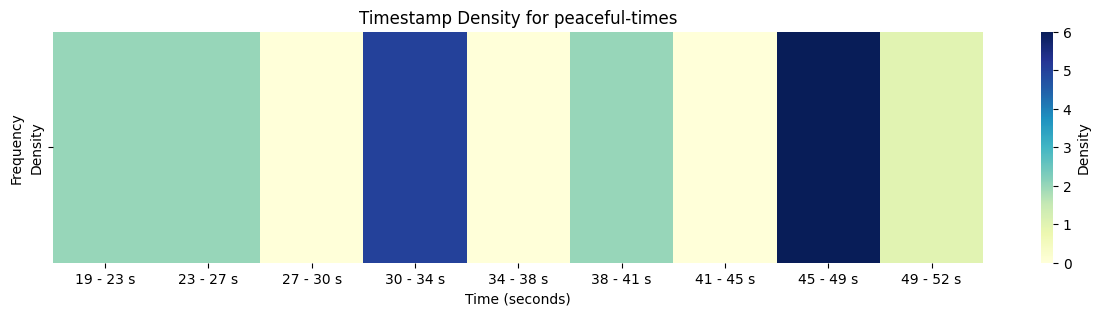

mkdir: test8: File exists


timestamps: [26.357333333333333, 33.00266666666667, 33.00266666666667, 46.154666666666664, 19.797333333333334, 46.154666666666664, 33.00266666666667, 19.797333333333334, 46.154666666666664, 26.357333333333333, 52.72533333333333, 46.154666666666664, 39.57333333333333, 46.154666666666664, 46.154666666666664, 33.00266666666667, 39.57333333333333, 33.00266666666667]
From file we recognized: [b'12.117333333333333_19.626666666666665', b'41.99466666666667_49.376']

Fingerprinting channel 1/2 for test8/slices/27.2_34.784.mp3
Finished channel 1/2 for test8/slices/27.2_34.784.mp3
Fingerprinting channel 2/2 for test8/slices/27.2_34.784.mp3
Finished channel 2/2 for test8/slices/27.2_34.784.mp3
From file we recognized: [b'145.984_153.32266666666666', b'56.98133333333333_64.50133333333333']

Fingerprinting channel 1/2 for test8/slices/108.87466666666667_116.0.mp3
Finished channel 1/2 for test8/slices/108.87466666666667_116.0.mp3
Fingerprinting channel 2/2 for test8/slices/108.87466666666667_116.0.mp

rm: test8/results.txt: No such file or directory


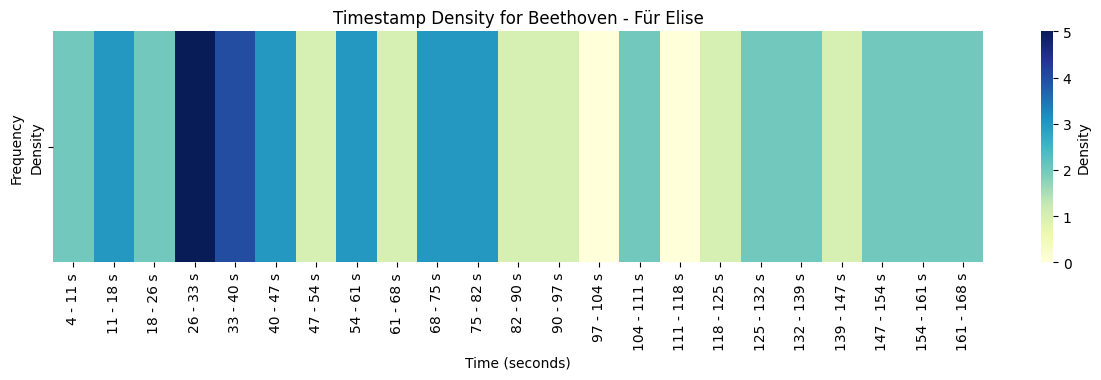

timestamps: [12.117333333333333, 41.99466666666667, 145.984, 56.98133333333333, 64.50133333333333, 108.87466666666667, 94.25066666666666, 12.117333333333333, 79.36, 71.88266666666667, 79.36, 41.99466666666667, 27.2, 41.99466666666667, 138.464, 27.2, 168.37333333333333, 153.32266666666666, 71.88266666666667, 138.464, 56.98133333333333, 71.88266666666667, 123.392, 34.784, 130.88, 86.77333333333333, 12.117333333333333, 27.2, 160.864, 153.32266666666666, 160.864, 168.37333333333333, 19.626666666666665, 27.2, 79.36, 34.784, 108.87466666666667, 56.98133333333333, 4.704, 27.2, 34.784, 4.704, 34.784, 49.376, 19.626666666666665, 130.88]


mkdir: test9: File exists


From file we recognized: [b'173.81333333333333_179.584', b'179.584_185.38666666666666']

Fingerprinting channel 1/2 for test9/slices/185.38666666666666_190.74133333333333.mp3
Finished channel 1/2 for test9/slices/185.38666666666666_190.74133333333333.mp3
Fingerprinting channel 2/2 for test9/slices/185.38666666666666_190.74133333333333.mp3
Finished channel 2/2 for test9/slices/185.38666666666666_190.74133333333333.mp3
From file we recognized: [b'150.15466666666666_156.10666666666665', b'1.6746666666666667_7.594666666666667']

Fingerprinting channel 1/2 for test9/slices/162.016_167.85066666666665.mp3
Finished channel 1/2 for test9/slices/162.016_167.85066666666665.mp3
Fingerprinting channel 2/2 for test9/slices/162.016_167.85066666666665.mp3
Finished channel 2/2 for test9/slices/162.016_167.85066666666665.mp3
From file we recognized: [b'13.557333333333334_19.434666666666665', b'19.434666666666665_25.237333333333332']

Fingerprinting channel 1/2 for test9/slices/132.13866666666667_138.165

rm: test9/results.txt: No such file or directory


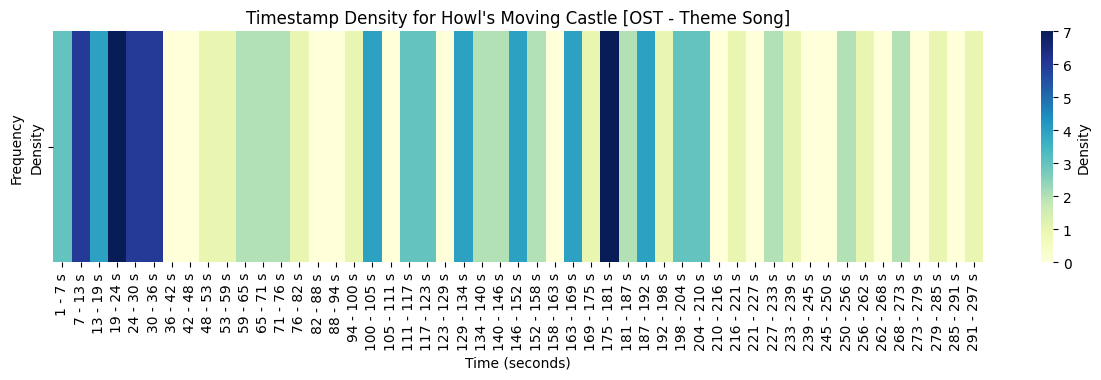

timestamps: [173.81333333333333, 179.584, 150.15466666666666, 1.6746666666666667, 13.557333333333334, 19.434666666666665, 132.13866666666667, 25.237333333333332, 202.25066666666666, 7.594666666666667, 208.08533333333332, 13.557333333333334, 150.15466666666666, 156.10666666666665, 7.594666666666667, 13.557333333333334, 19.434666666666665, 25.237333333333332, 72.62933333333334, 208.08533333333332, 114.21866666666666, 179.584, 273.504, 167.85066666666665, 132.13866666666667, 31.253333333333334, 261.856, 150.15466666666666, 49.056, 54.922666666666665, 19.434666666666665, 31.253333333333334, 202.25066666666666, 13.557333333333334, 25.237333333333332, 102.41066666666667, 202.25066666666666, 120.05333333333333, 232.224, 190.74133333333333, 19.434666666666665, 31.253333333333334, 150.15466666666666, 179.584, 25.237333333333332, 220.36266666666666, 120.05333333333333, 190.74133333333333, 19.434666666666665, 25.237333333333332, 179.584, 120.05333333333333, 114.21866666666666, 256.1173333333333, 

mkdir: test10: File exists


Failed fingerprinting
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/kevinhu/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/kevinhu/dejavu/dejavu/__init__.py", line 364, in _fingerprint_worker
    fingerprints, file_hash = Dejavu.get_file_fingerprints(file_name, limit, print_output=True)
  File "/Users/kevinhu/dejavu/dejavu/__init__.py", line 370, in get_file_fingerprints
    channels, fs, file_hash = decoder.read(file_name, limit)
  File "/Users/kevinhu/dejavu/dejavu/logic/decoder.py", line 70, in read
    audiofile = AudioSegment.from_file(file_name)
  File "/Users/kevinhu/.pyenv/versions/3.8.11/lib/python3.8/site-packages/pydub/audio_segment.py", line 773, in from_file
    raise CouldntDecodeError(
pydub.exceptions.CouldntDecodeError: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 6.0 Copyright (c) 2000-2

mkdir: test11: File exists


From file we recognized: [b'227.584_239.01866666666666', b'114.02666666666667_125.41866666666667']

Fingerprinting channel 1/2 for test11/slices/0.448_11.509333333333334.mp3
Finished channel 1/2 for test11/slices/0.448_11.509333333333334.mp3
Fingerprinting channel 2/2 for test11/slices/0.448_11.509333333333334.mp3
Finished channel 2/2 for test11/slices/0.448_11.509333333333334.mp3
From file we recognized: [b'23.221333333333334_34.730666666666664', b'69.024_79.744']

Fingerprinting channel 1/2 for test11/slices/57.22666666666667_69.024.mp3
Finished channel 1/2 for test11/slices/57.22666666666667_69.024.mp3
Fingerprinting channel 2/2 for test11/slices/57.22666666666667_69.024.mp3
Finished channel 2/2 for test11/slices/57.22666666666667_69.024.mp3
From file we recognized: [b'170.44266666666667_181.71733333333333', b'193.29066666666668_204.72533333333334']

Fingerprinting channel 1/2 for test11/slices/181.71733333333333_193.29066666666668.mp3
Finished channel 1/2 for test11/slices/181.7173

rm: test11/results.txt: No such file or directory


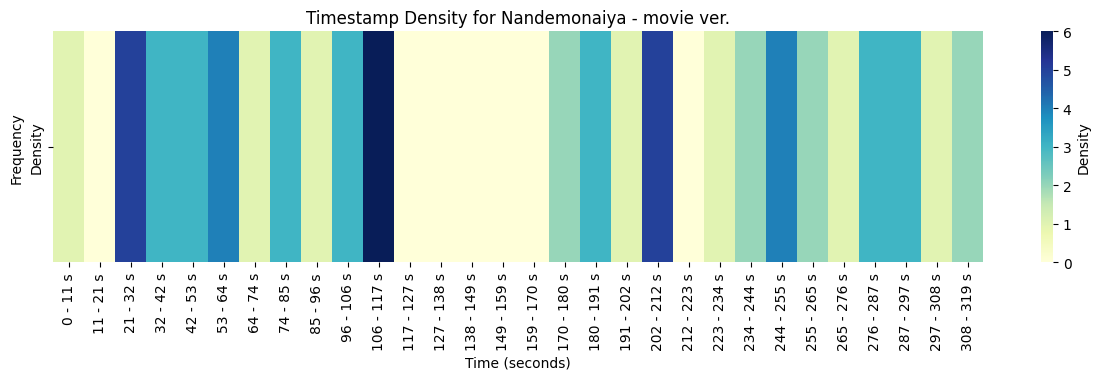

timestamps: [227.584, 114.02666666666667, 23.221333333333334, 69.024, 170.44266666666667, 193.29066666666668, 79.744, 45.80266666666667, 261.888, 114.02666666666667, 181.71733333333333, 239.01866666666666, 204.72533333333334, 284.736, 34.730666666666664, 91.136, 114.02666666666667, 261.888, 296.14933333333335, 250.45333333333335, 114.02666666666667, 239.01866666666666, 296.14933333333335, 250.45333333333335, 102.58133333333333, 23.221333333333334, 79.744, 57.22666666666667, 319.008, 296.14933333333335, 250.45333333333335, 170.44266666666667, 34.730666666666664, 23.221333333333334, 45.80266666666667, 114.02666666666667, 284.736, 204.72533333333334, 114.02666666666667, 204.72533333333334, 57.22666666666667, 181.71733333333333, 57.22666666666667, 23.221333333333334, 45.80266666666667, 307.5733333333333, 204.72533333333334, 273.29066666666665, 102.58133333333333, 57.22666666666667, 181.71733333333333, 79.744, 34.730666666666664, 23.221333333333334, 0.448, 250.45333333333335, 204.7253333333

mkdir: test12: File exists


From file we recognized: [b'49.09866666666667_56.842666666666666', b'41.269333333333336_49.09866666666667']

Fingerprinting channel 1/2 for test12/slices/172.43733333333333_180.11733333333333.mp3
Finished channel 1/2 for test12/slices/172.43733333333333_180.11733333333333.mp3
Fingerprinting channel 2/2 for test12/slices/172.43733333333333_180.11733333333333.mp3
Finished channel 2/2 for test12/slices/172.43733333333333_180.11733333333333.mp3
From file we recognized: [b'210.528_218.4', b'203.08266666666665_210.528']

Fingerprinting channel 1/2 for test12/slices/111.06133333333334_118.752.mp3
Finished channel 1/2 for test12/slices/111.06133333333334_118.752.mp3
Fingerprinting channel 2/2 for test12/slices/111.06133333333334_118.752.mp3
Finished channel 2/2 for test12/slices/111.06133333333334_118.752.mp3
From file we recognized: [b'149.19466666666668_156.928', b'49.09866666666667_56.842666666666666']

Fingerprinting channel 1/2 for test12/slices/141.51466666666667_149.19466666666668.mp3
F

rm: test12/results.txt: No such file or directory


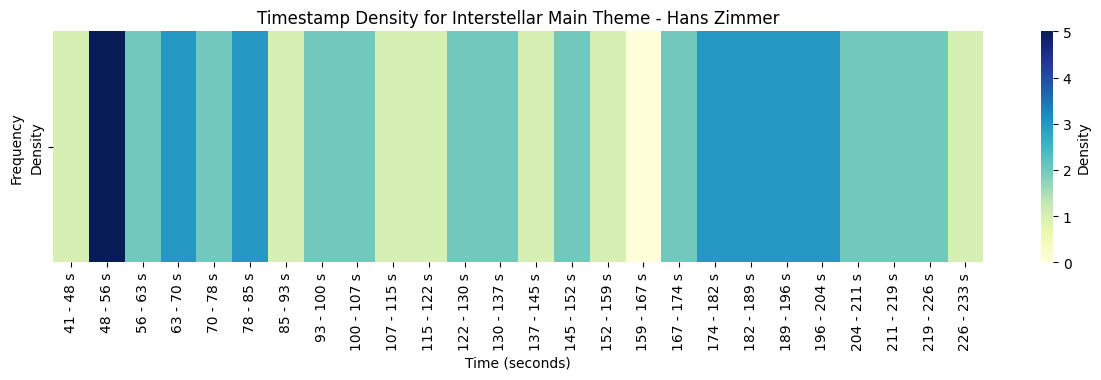

timestamps: [49.09866666666667, 41.269333333333336, 210.528, 203.08266666666665, 149.19466666666668, 49.09866666666667, 180.11733333333333, 172.43733333333333, 195.296, 95.70133333333334, 233.93066666666667, 226.336, 180.11733333333333, 80.192, 226.336, 218.4, 203.08266666666665, 195.296, 218.4, 210.528, 49.09866666666667, 80.192, 56.842666666666666, 187.81866666666667, 195.296, 64.52266666666667, 95.70133333333334, 64.52266666666667, 103.424, 72.36266666666667, 49.09866666666667, 187.81866666666667, 180.11733333333333, 49.09866666666667, 134.18666666666667, 72.36266666666667, 149.19466666666668, 172.43733333333333, 203.08266666666665, 103.424, 141.51466666666667, 156.928, 118.752, 126.656, 56.842666666666666, 64.52266666666667, 111.06133333333334, 80.192, 126.656, 134.18666666666667, 187.81866666666667, 88.10666666666667]


mkdir: test13: File exists


From file we recognized: [b'82.784_95.92533333333333', b'95.92533333333333_109.55733333333333']

Fingerprinting channel 1/2 for test13/slices/1.3866666666666667_14.688.mp3
Finished channel 1/2 for test13/slices/1.3866666666666667_14.688.mp3
Fingerprinting channel 2/2 for test13/slices/1.3866666666666667_14.688.mp3
Finished channel 2/2 for test13/slices/1.3866666666666667_14.688.mp3
From file we recognized: [b'28.341333333333335_41.962666666666664', b'14.688_28.341333333333335']

Fingerprinting channel 1/2 for test13/slices/109.55733333333333_123.17866666666667.mp3
Finished channel 1/2 for test13/slices/109.55733333333333_123.17866666666667.mp3
Fingerprinting channel 2/2 for test13/slices/109.55733333333333_123.17866666666667.mp3
Finished channel 2/2 for test13/slices/109.55733333333333_123.17866666666667.mp3
From file we recognized: [b'41.962666666666664_55.605333333333334', b'28.341333333333335_41.962666666666664']

Fingerprinting channel 1/2 for test13/slices/123.17866666666667_136.8

rm: test13/results.txt: No such file or directory


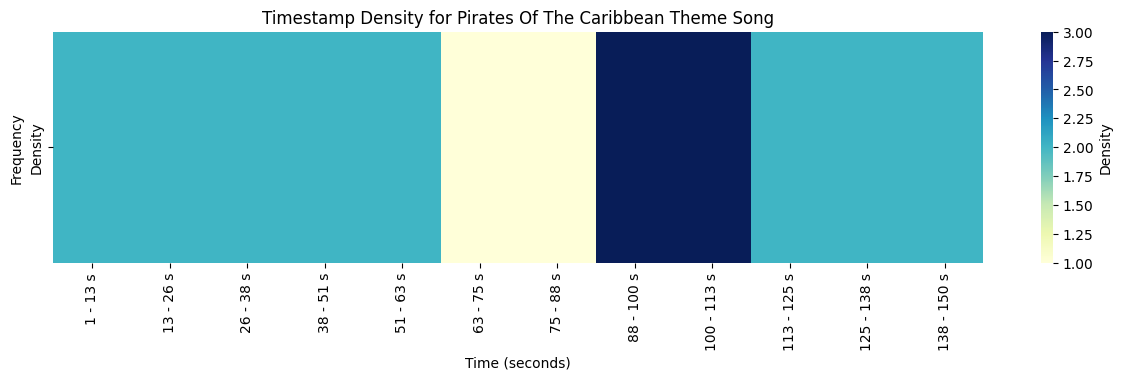

mkdir: test14: File exists


timestamps: [82.784, 95.92533333333333, 28.341333333333335, 14.688, 41.962666666666664, 28.341333333333335, 123.17866666666667, 136.82133333333334, 136.82133333333334, 150.464, 109.55733333333333, 123.17866666666667, 95.92533333333333, 109.55733333333333, 55.605333333333334, 69.22666666666667, 14.688, 1.3866666666666667, 1.3866666666666667, 95.92533333333333, 55.605333333333334, 41.962666666666664, 150.464, 109.55733333333333]
From file we recognized: [b'139.648_148.37333333333333', b'35.18933333333333_43.91466666666667']

Fingerprinting channel 1/2 for test14/slices/130.92266666666666_139.648.mp3
Finished channel 1/2 for test14/slices/130.92266666666666_139.648.mp3
Fingerprinting channel 2/2 for test14/slices/130.92266666666666_139.648.mp3
Finished channel 2/2 for test14/slices/130.92266666666666_139.648.mp3
From file we recognized: [b'35.18933333333333_43.91466666666667', b'52.650666666666666_61.376']

Fingerprinting channel 1/2 for test14/slices/26.464_35.18933333333333.mp3
Finished

rm: test14/results.txt: No such file or directory


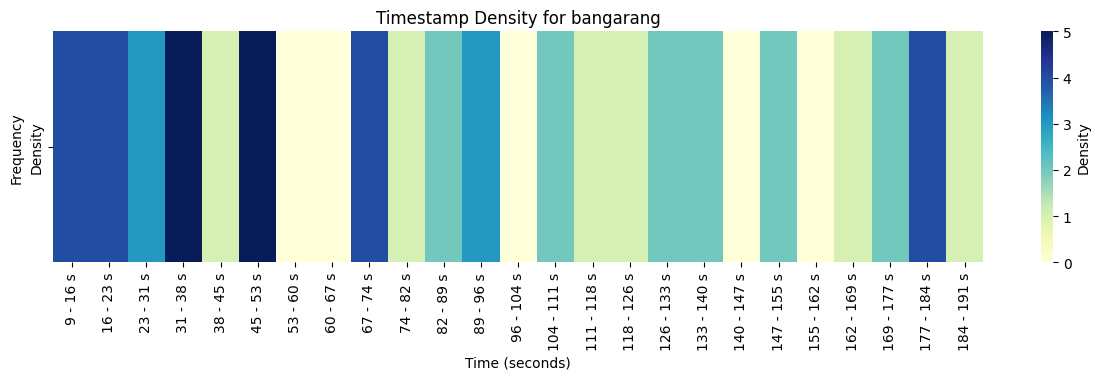

timestamps: [139.648, 35.18933333333333, 35.18933333333333, 52.650666666666666, 122.19733333333333, 26.464, 52.650666666666666, 191.744, 9.28, 17.984, 183.008, 52.650666666666666, 183.008, 26.464, 17.984, 9.28, 17.984, 70.25066666666666, 35.18933333333333, 52.650666666666666, 87.552, 96.27733333333333, 148.37333333333333, 9.28, 113.73866666666666, 52.650666666666666, 139.648, 130.92266666666666, 70.25066666666666, 17.984, 35.18933333333333, 70.25066666666666, 26.464, 43.91466666666667, 174.28266666666667, 35.18933333333333, 96.27733333333333, 174.28266666666667, 165.6, 183.008, 130.92266666666666, 148.37333333333333, 105.01333333333334, 183.008, 96.27733333333333, 78.816, 9.28, 70.25066666666666, 87.552, 105.01333333333334]


mkdir: test15: File exists


From file we recognized: [b'24.341333333333335_37.013333333333335', b'37.013333333333335_48.266666666666666']

Fingerprinting channel 1/2 for test15/slices/82.89066666666666_94.28266666666667.mp3
Finished channel 1/2 for test15/slices/82.89066666666666_94.28266666666667.mp3
Fingerprinting channel 2/2 for test15/slices/82.89066666666666_94.28266666666667.mp3
Finished channel 2/2 for test15/slices/82.89066666666666_94.28266666666667.mp3
From file we recognized: [b'48.266666666666666_59.52', b'24.341333333333335_37.013333333333335']

Fingerprinting channel 1/2 for test15/slices/71.40266666666666_82.89066666666666.mp3
Finished channel 1/2 for test15/slices/71.40266666666666_82.89066666666666.mp3
Fingerprinting channel 2/2 for test15/slices/71.40266666666666_82.89066666666666.mp3
Finished channel 2/2 for test15/slices/71.40266666666666_82.89066666666666.mp3
From file we recognized: [b'71.40266666666666_82.89066666666666', b'48.266666666666666_59.52']

Fingerprinting channel 1/2 for test15/s

rm: test15/results.txt: No such file or directory


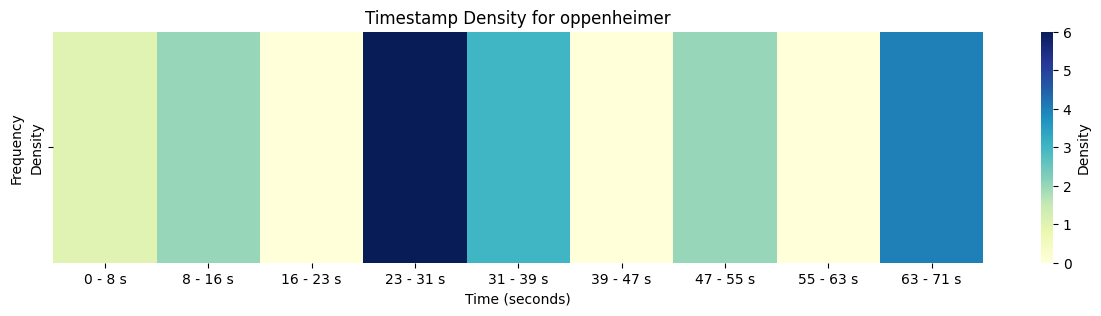

mkdir: test16: File exists


timestamps: [24.341333333333335, 37.013333333333335, 48.266666666666666, 24.341333333333335, 71.40266666666666, 48.266666666666666, 24.341333333333335, 12.501333333333333, 37.013333333333335, 71.40266666666666, 24.341333333333335, 71.40266666666666, 0.224, 24.341333333333335, 71.40266666666666, 37.013333333333335, 24.341333333333335, 12.501333333333333]
From file we recognized: [b'39.38133333333333_47.06133333333333', b'47.06133333333333_54.74133333333333']

Fingerprinting channel 1/2 for test16/slices/31.690666666666665_39.38133333333333.mp3
Finished channel 1/2 for test16/slices/31.690666666666665_39.38133333333333.mp3
Fingerprinting channel 2/2 for test16/slices/31.690666666666665_39.38133333333333.mp3
Finished channel 2/2 for test16/slices/31.690666666666665_39.38133333333333.mp3
From file we recognized: [b'23.776_31.690666666666665', b'124.10666666666667_131.78666666666666']

Fingerprinting channel 1/2 for test16/slices/16.096_23.776.mp3
Finished channel 1/2 for test16/slices/16.0

rm: test16/results.txt: No such file or directory


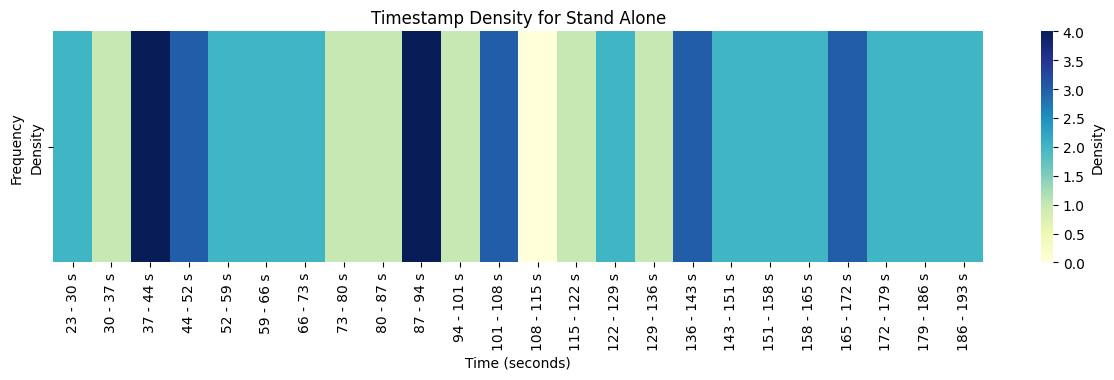

timestamps: [39.38133333333333, 47.06133333333333, 23.776, 124.10666666666667, 124.10666666666667, 155.06133333333332, 93.14133333333334, 108.50133333333333, 23.776, 93.14133333333334, 170.42133333333334, 193.46133333333333, 147.14666666666668, 139.46666666666667, 85.46133333333333, 39.38133333333333, 62.432, 77.77066666666667, 139.46666666666667, 147.14666666666668, 100.82133333333333, 108.50133333333333, 131.78666666666666, 162.74133333333333, 70.112, 54.74133333333333, 170.42133333333334, 193.46133333333333, 62.432, 70.112, 162.74133333333333, 139.46666666666667, 116.18133333333333, 93.14133333333334, 108.50133333333333, 93.14133333333334, 47.06133333333333, 39.38133333333333, 185.78133333333332, 178.10133333333334, 31.690666666666665, 47.06133333333333, 185.78133333333332, 178.10133333333334, 170.42133333333334, 155.06133333333332, 54.74133333333333, 39.38133333333333]


mkdir: test17: File exists


From file we recognized: [b'12.821333333333333_22.442666666666668', b'125.17333333333333_134.26133333333334']

Fingerprinting channel 1/2 for test17/slices/234.67733333333334_236.128.mp3
Finished channel 1/2 for test17/slices/234.67733333333334_236.128.mp3
Fingerprinting channel 2/2 for test17/slices/234.67733333333334_236.128.mp3
Finished channel 2/2 for test17/slices/234.67733333333334_236.128.mp3
From file we recognized: [b'134.26133333333334_143.08266666666665', b'215.98933333333332_225.38666666666666']

Fingerprinting channel 1/2 for test17/slices/143.08266666666665_152.352.mp3
Finished channel 1/2 for test17/slices/143.08266666666665_152.352.mp3
Fingerprinting channel 2/2 for test17/slices/143.08266666666665_152.352.mp3
Finished channel 2/2 for test17/slices/143.08266666666665_152.352.mp3
From file we recognized: [b'97.44_106.80533333333334', b'88.36266666666667_97.44']

Fingerprinting channel 1/2 for test17/slices/106.80533333333334_116.032.mp3
Finished channel 1/2 for test17/sl

rm: test17/results.txt: No such file or directory
/var/folders/1j/pw9mgg8s4t3_ntbq0r7842sm0000gn/T/ipykernel_74200/3360583.py:8: UserWarning: Glyph 12300 (\N{LEFT CORNER BRACKET}) missing from current font.
  plt.savefig(save_dir + 'output.png')
/var/folders/1j/pw9mgg8s4t3_ntbq0r7842sm0000gn/T/ipykernel_74200/3360583.py:8: UserWarning: Glyph 12301 (\N{RIGHT CORNER BRACKET}) missing from current font.
  plt.savefig(save_dir + 'output.png')
/Users/kevinhu/.pyenv/versions/3.8.11/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12300 (\N{LEFT CORNER BRACKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kevinhu/.pyenv/versions/3.8.11/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12301 (\N{RIGHT CORNER BRACKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


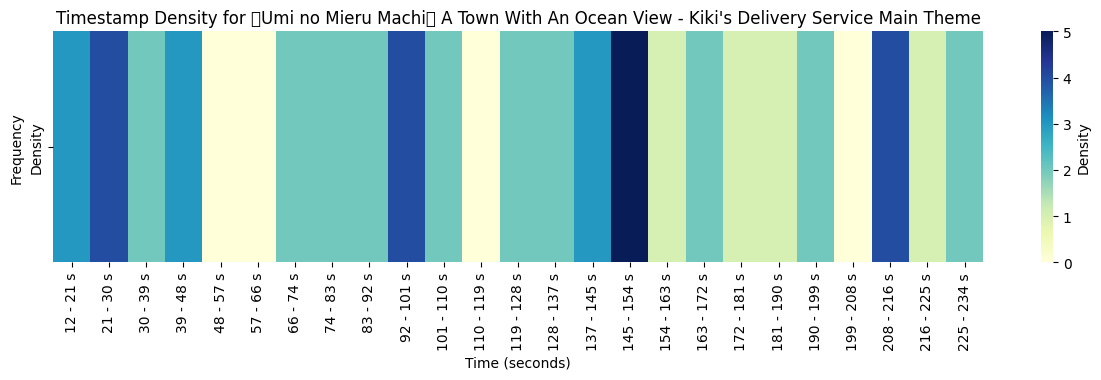

timestamps: [12.821333333333333, 125.17333333333333, 134.26133333333334, 215.98933333333332, 97.44, 88.36266666666667, 88.36266666666667, 78.912, 225.38666666666666, 22.442666666666668, 41.504, 170.592, 215.98933333333332, 152.352, 106.80533333333334, 161.344, 152.352, 143.08266666666665, 215.98933333333332, 22.442666666666668, 179.94666666666666, 170.592, 41.504, 12.821333333333333, 125.17333333333333, 152.352, 197.94133333333335, 134.26133333333334, 97.44, 143.08266666666665, 31.968, 22.442666666666668, 215.98933333333332, 31.968, 41.504, 106.80533333333334, 97.44, 69.408, 12.821333333333333, 69.408, 78.912, 234.67733333333334, 152.352, 188.896, 197.94133333333335, 97.44, 234.67733333333334, 143.08266666666665, 152.352, 22.442666666666668]


rm: test18/slices: No such file or directory


From file we recognized: [b'198.03733333333332_205.65333333333334', b'144.71466666666666_152.33066666666667']

Fingerprinting channel 1/2 for test18/slices/106.60266666666666_114.208.mp3
Finished channel 1/2 for test18/slices/106.60266666666666_114.208.mp3
Fingerprinting channel 2/2 for test18/slices/106.60266666666666_114.208.mp3
Finished channel 2/2 for test18/slices/106.60266666666666_114.208.mp3
From file we recognized: [b'159.94666666666666_167.552', b'144.71466666666666_152.33066666666667']

Fingerprinting channel 1/2 for test18/slices/175.18933333333334_182.82666666666665.mp3
Finished channel 1/2 for test18/slices/175.18933333333334_182.82666666666665.mp3
Fingerprinting channel 2/2 for test18/slices/175.18933333333334_182.82666666666665.mp3
Finished channel 2/2 for test18/slices/175.18933333333334_182.82666666666665.mp3
From file we recognized: [b'190.42133333333334_198.03733333333332', b'121.83466666666666_129.472']

Fingerprinting channel 1/2 for test18/slices/205.653333333333

rm: test18/results.txt: No such file or directory


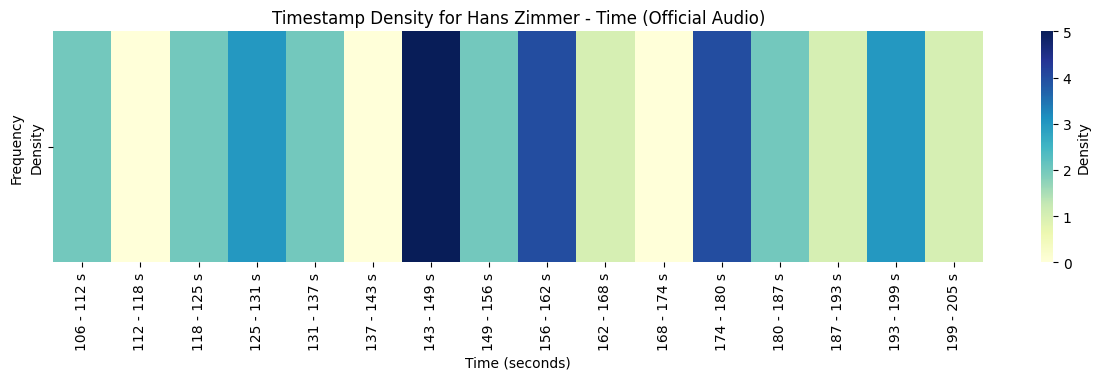

timestamps: [198.03733333333332, 144.71466666666666, 159.94666666666666, 144.71466666666666, 190.42133333333334, 121.83466666666666, 175.18933333333334, 144.71466666666666, 152.33066666666667, 198.03733333333332, 129.472, 121.83466666666666, 129.472, 159.94666666666666, 182.82666666666665, 198.03733333333332, 182.82666666666665, 152.33066666666667, 137.088, 159.94666666666666, 129.472, 167.552, 175.18933333333334, 106.60266666666666, 144.71466666666666, 137.088, 205.65333333333334, 175.18933333333334, 159.94666666666666, 175.18933333333334, 144.71466666666666, 106.60266666666666]


In [104]:
test_dir = "test_files/"
timestamps_set = []
for test_num, filename in enumerate(os.listdir("test_files/")):
    if len(filename) <= 4 or filename[-4:len(filename)] != ".mp3":
        continue
    input_file = test_dir + filename
    name = filename.split(".mp3")[0]
    dir = f"test{test_num+1}/"
    try:
        timestamps, timestamps_graph, song_ids, binsize = analyze_non_lyrical(input_file, dir)
    except TypeError as e:
        print(f"Failed to run non-lyrical analysis on {filename}: Nonetype returned")
        continue
    timestamps_set.append((name, timestamps))
    hist_data, bins = np.histogram(timestamps, bins=binsize) # Adjust the number of bins if needed
    
    sorted_moments = sorted(song_ids.keys(), key=lambda x: float(x.split("_")[0]))
    print(f"sorted_moments: {sorted_moments}")

    max_value = np.max(hist_data)
    most_common_moments = np.where(hist_data == max_value)

    print(f"most_common_moments: {most_common_moments} and type: {type(most_common_moments)}")
    subprocess.run(["rm", dir+"results.txt"], check=False)
    with open(dir+"key_moments.txt", "a") as f:
        for array in most_common_moments:
            print(f"writing the string: {array[0]}")
            f.write(str(sorted_moments[array[0]]))

    hist_data = hist_data.reshape(-1, 1) # Normalizing the hist_data for the heatmap
    
    time_labels = [(f"{int(bins[i])} - {int(bins[i+1])} s") for i in range(len(bins) - 1)] # Define the time labels for the x-axis
    
    # Create a DataFrame to hold the data
    df = pd.DataFrame(hist_data, columns=['Density'])
    df.index = time_labels
    df = df.T
    plot_histogram(name, dir, timestamps, binsize, df)
    print(f"timestamps: {timestamps}")

In [52]:
timestamps_set = []
name = "sdp_interlude"
timestamps_set.append((name, timestamps))

In [35]:
#timestamps = [19.317333333333334, 156.736, 68.32, 123.89333333333333, 139.232, 76.992, 165.51466666666667, 47.349333333333334, 59.626666666666665, 66.57066666666667, 85.67466666666667, 61.42933333333333, 111.88266666666667, 146.26133333333334, 47.349333333333334, 146.26133333333334, 146.26133333333334, 165.51466666666667, 135.82933333333332, 73.52533333333334, 61.42933333333333, 75.27466666666666, 56.14933333333333, 76.992, 57.86666666666667, 140.96, 73.52533333333334, 135.82933333333332, 130.752, 137.55733333333333, 70.03733333333334, 76.992, 140.96, 134.09066666666666, 37.152, 168.87466666666666, 154.944, 137.55733333333333, 52.704, 70.03733333333334, 76.992, 64.82133333333333, 140.96, 73.52533333333334, 66.57066666666667, 68.32, 52.704, 76.992, 70.03733333333334, 71.744, 64.82133333333333, 80.55466666666666, 37.152, 15.765333333333333, 52.704, 47.349333333333334, 165.51466666666667, 40.544, 45.77066666666666, 89.088, 47.349333333333334, 6.986666666666666, 161.94133333333335, 170.66666666666666, 66.57066666666667, 70.03733333333334, 76.992, 87.34933333333333, 47.349333333333334, 160.21333333333334, 161.94133333333335, 161.94133333333335, 168.87466666666666, 44.096, 8.704, 45.77066666666666, 167.14666666666668, 87.34933333333333, 38.858666666666664, 89.088, 47.349333333333334, 30.261333333333333, 89.088, 37.152, 179.41333333333333, 8.704, 24.8, 28.426666666666666, 66.57066666666667, 32.053333333333335, 47.349333333333334, 49.205333333333336, 96.13866666666667, 26.634666666666668, 94.34666666666666, 37.152, 82.26133333333334, 80.55466666666666, 26.634666666666668, 45.77066666666666, 92.58666666666667, 186.41066666666666, 208.98133333333334, 99.712, 47.349333333333334, 207.27466666666666, 208.98133333333334, 30.261333333333333, 38.858666666666664, 99.712, 38.858666666666664, 40.544, 42.29333333333334, 47.349333333333334, 33.76, 44.096, 42.29333333333334, 45.77066666666666, 47.349333333333334, 89.088, 49.205333333333336, 42.29333333333334, 97.92, 47.349333333333334, 80.55466666666666, 44.096, 40.544, 61.42933333333333, 87.34933333333333, 92.58666666666667, 97.92, 90.83733333333333, 76.992, 57.86666666666667, 85.67466666666667, 94.34666666666666, 89.088, 87.34933333333333, 78.77333333333333, 57.86666666666667, 57.86666666666667, 59.626666666666665, 85.67466666666667, 54.42133333333334, 68.32, 85.67466666666667, 76.992, 63.093333333333334, 78.77333333333333, 64.82133333333333, 61.42933333333333, 76.992, 66.57066666666667, 68.32, 85.67466666666667, 66.57066666666667, 76.992, 70.03733333333334, 71.744, 78.77333333333333, 68.32, 75.27466666666666, 75.27466666666666, 85.67466666666667, 76.992, 75.27466666666666, 78.77333333333333, 75.27466666666666, 75.27466666666666, 76.992, 78.77333333333333, 87.34933333333333, 96.13866666666667, 90.83733333333333, 85.67466666666667, 87.34933333333333, 90.83733333333333, 94.34666666666666, 87.34933333333333, 92.58666666666667, 96.13866666666667, 97.92, 99.712, 97.92, 94.34666666666666, 96.13866666666667, 99.712]
#timestamps = [10.453333333333333, 10.453333333333333, 101.52533333333334, 101.52533333333334, 103.2, 103.2, 104.84266666666667, 104.84266666666667, 106.58133333333333, 42.29333333333334, 108.576, 108.576, 110.21866666666666, 47.349333333333334, 111.88266666666667, 111.88266666666667, 113.6, 71.744, 115.31733333333334, 115.31733333333334, 117.056, 61.42933333333333, 118.752, 132.416, 12.202666666666667, 179.41333333333333, 120.448, 120.448, 122.15466666666667, 129.03466666666668, 123.89333333333333, 123.89333333333333, 125.58933333333333, 125.58933333333333, 127.30666666666667, 127.30666666666667, 129.03466666666668, 135.82933333333332, 13.952, 21.109333333333332, 130.752, 137.55733333333333, 132.416, 132.416, 134.09066666666666, 134.09066666666666, 135.82933333333332, 135.82933333333332, 137.55733333333333, 130.752, 139.232, 63.093333333333334, 140.96, 71.744, 142.67733333333334, 142.67733333333334, 144.384, 144.384, 146.26133333333334, 146.26133333333334, 148.02133333333333, 146.26133333333334, 149.80266666666665, 149.80266666666665, 15.765333333333333, 123.89333333333333, 151.424, 28.426666666666666, 153.152, 153.152, 154.944, 154.944, 156.736, 54.42133333333334, 158.464, 158.464, 160.21333333333334, 160.21333333333334, 161.94133333333335, 161.94133333333335, 163.59466666666665, 163.59466666666665, 165.51466666666667, 165.51466666666667, 167.14666666666668, 35.46666666666667, 168.87466666666666, 168.87466666666666, 17.536, 17.536, 170.66666666666666, 47.349333333333334, 172.45866666666666, 172.45866666666666, 174.25066666666666, 174.25066666666666, 175.95733333333334, 175.95733333333334, 177.664, 177.664, 179.41333333333333, 179.41333333333333, 181.16266666666667, 181.16266666666667, 182.912, 182.912, 184.66133333333335, 184.66133333333335, 186.41066666666666, 22.901333333333334, 188.16, 144.384, 189.90933333333334, 144.384, 19.317333333333334, 19.317333333333334, 191.65866666666668, 193.408, 12.202666666666667, 195.15733333333333, 184.66133333333335, 196.90666666666667, 205.52533333333332, 198.624, 198.624, 200.256, 200.256, 201.83466666666666, 200.256, 203.73333333333332, 203.73333333333332, 205.52533333333332, 196.90666666666667, 207.27466666666666, 207.27466666666666, 208.98133333333334, 208.98133333333334, 21.109333333333332, 170.66666666666666, 22.901333333333334, 22.901333333333334, 24.8, 24.8, 26.634666666666668, 26.634666666666668, 28.426666666666666, 28.426666666666666, 30.261333333333333, 30.261333333333333, 32.053333333333335, 32.053333333333335, 33.76, 33.76, 35.46666666666667, 35.46666666666667, 37.152, 149.80266666666665, 38.858666666666664, 22.901333333333334, 40.544, 40.544, 42.29333333333334, 42.29333333333334, 44.096, 44.096, 45.77066666666666, 45.77066666666666, 47.349333333333334, 32.053333333333335, 49.205333333333336, 49.205333333333336, 50.95466666666667, 50.95466666666667, 52.704, 163.59466666666665, 54.42133333333334, 54.42133333333334, 56.14933333333333, 56.14933333333333, 57.86666666666667, 57.86666666666667, 59.626666666666665, 59.626666666666665, 6.986666666666666, 103.2, 61.42933333333333, 103.2, 63.093333333333334, 63.093333333333334, 64.82133333333333, 132.416, 66.57066666666667, 73.52533333333334, 68.32, 68.32, 70.03733333333334, 70.03733333333334, 71.744, 140.96, 73.52533333333334, 66.57066666666667, 75.27466666666666, 75.27466666666666, 76.992, 139.232, 78.77333333333333, 78.77333333333333, 8.704, 8.704, 80.55466666666666, 80.55466666666666, 82.26133333333334, 82.26133333333334, 83.968, 83.968, 85.67466666666667, 85.67466666666667, 87.34933333333333, 87.34933333333333, 89.088, 89.088, 90.83733333333333, 94.34666666666666, 92.58666666666667, 45.77066666666666, 94.34666666666666, 94.34666666666666, 96.13866666666667, 32.053333333333335, 97.92, 97.92, 99.712, 99.712]
# timestamps = [10.453333333333333, 19.317333333333334, 101.52533333333334, 85.67466666666667, 103.2, 22.901333333333334, 104.84266666666667, 24.8, 106.58133333333333, 42.29333333333334, 108.576, 45.77066666666666, 110.21866666666666, 47.349333333333334, 111.88266666666667, 32.053333333333335, 113.6, 71.744, 115.31733333333334, 135.82933333333332, 117.056, 61.42933333333333, 118.752, 132.416, 12.202666666666667, 179.41333333333333, 120.448, 127.30666666666667, 122.15466666666667, 129.03466666666668, 123.89333333333333, 130.752, 125.58933333333333, 63.093333333333334, 127.30666666666667, 134.09066666666666, 129.03466666666668, 135.82933333333332, 13.952, 21.109333333333332, 130.752, 137.55733333333333, 132.416, 118.752, 134.09066666666666, 127.30666666666667, 135.82933333333332, 129.03466666666668, 137.55733333333333, 130.752, 139.232, 63.093333333333334, 140.96, 71.744, 142.67733333333334, 160.21333333333334, 144.384, 161.94133333333335, 146.26133333333334, 148.02133333333333, 148.02133333333333, 146.26133333333334, 149.80266666666665, 37.152, 15.765333333333333, 123.89333333333333, 151.424, 28.426666666666666, 153.152, 168.87466666666666, 154.944, 151.424, 156.736, 54.42133333333334, 158.464, 50.95466666666667, 160.21333333333334, 142.67733333333334, 161.94133333333335, 144.384, 163.59466666666665, 87.34933333333333, 165.51466666666667, 89.088, 167.14666666666668, 35.46666666666667, 168.87466666666666, 151.424, 17.536, 8.704, 170.66666666666666, 47.349333333333334, 172.45866666666666, 142.67733333333334, 174.25066666666666, 156.736, 175.95733333333334, 113.6, 177.664, 28.426666666666666, 179.41333333333333, 151.424, 181.16266666666667, 146.26133333333334, 182.912, 108.576, 184.66133333333335, 174.25066666666666, 186.41066666666666, 188.16, 188.16, 144.384, 189.90933333333334, 144.384, 19.317333333333334, 10.453333333333333, 191.65866666666668, 193.408, 12.202666666666667, 195.15733333333333, 19.317333333333334, 196.90666666666667, 205.52533333333332, 198.624, 196.90666666666667, 200.256, 201.83466666666666, 201.83466666666666, 200.256, 203.73333333333332, 201.83466666666666, 205.52533333333332, 196.90666666666667, 207.27466666666666, 205.52533333333332, 208.98133333333334, 200.256, 21.109333333333332, 170.66666666666666, 22.901333333333334, 85.67466666666667, 24.8, 89.088, 26.634666666666668, 89.088, 28.426666666666666, 151.424, 30.261333333333333, 94.34666666666666, 32.053333333333335, 96.13866666666667, 33.76, 49.205333333333336, 35.46666666666667, 49.205333333333336, 37.152, 149.80266666666665, 38.858666666666664, 22.901333333333334, 40.544, 24.8, 42.29333333333334, 106.58133333333333, 44.096, 108.576, 45.77066666666666, 108.576, 47.349333333333334, 32.053333333333335, 49.205333333333336, 160.21333333333334, 50.95466666666667, 35.46666666666667, 52.704, 163.59466666666665, 54.42133333333334, 22.901333333333334, 56.14933333333333, 125.58933333333333, 57.86666666666667, 71.744, 59.626666666666665, 122.15466666666667, 6.986666666666666, 13.952, 61.42933333333333, 103.2, 63.093333333333334, 125.58933333333333, 64.82133333333333, 132.416, 66.57066666666667, 73.52533333333334, 68.32, 75.27466666666666, 70.03733333333334, 125.58933333333333, 71.744, 140.96, 73.52533333333334, 66.57066666666667, 75.27466666666666, 68.32, 76.992, 139.232, 78.77333333333333, 127.30666666666667, 8.704, 17.536, 80.55466666666666, 142.67733333333334, 82.26133333333334, 151.424, 83.968, 21.109333333333332, 85.67466666666667, 22.901333333333334, 87.34933333333333, 163.59466666666665, 89.088, 149.80266666666665, 90.83733333333333, 94.34666666666666, 92.58666666666667, 45.77066666666666, 94.34666666666666, 30.261333333333333, 96.13866666666667, 32.053333333333335, 97.92, 149.80266666666665, 99.712, 110.21866666666666]

timestamps_set = []

name = "river_flows_in_you"
timestamps = [42.29333333333334, 28.426666666666666, 28.426666666666666, 118.752, 132.416, 125.58933333333333, 132.416, 70.03733333333334, 21.109333333333332, 6.986666666666666, 70.03733333333334, 63.093333333333334, 63.093333333333334, 70.03733333333334, 167.14666666666668, 21.109333333333332, 160.21333333333334, 167.14666666666668, 35.46666666666667, 49.205333333333336, 83.968, 21.109333333333332, 90.83733333333333, 76.992, 188.16, 42.29333333333334, 6.986666666666666, 195.15733333333333, 201.83466666666666, 208.98133333333334, 208.98133333333334, 28.426666666666666, 28.426666666666666, 97.92, 83.968, 35.46666666666667, 42.29333333333334, 90.83733333333333, 97.92, 49.205333333333336, 90.83733333333333, 83.968, 56.14933333333333, 70.03733333333334, 70.03733333333334, 63.093333333333334, 70.03733333333334, 83.968, 70.03733333333334, 76.992, 76.992, 97.92, 97.92, 90.83733333333333, 97.92, 90.83733333333333, 97.92]
timestamps_set.append((name, timestamps))
#fur_elise
name = "fur_elise"
timestamps = [94.25066666666666, 12.117333333333333, 145.984, 56.98133333333333, 49.376, 4.704, 27.2, 41.99466666666667, 71.88266666666667, 138.464, 79.36, 34.784, 4.704, 86.77333333333333, 56.98133333333333, 64.50133333333333, 168.37333333333333, 160.864, 168.37333333333333, 41.99466666666667, 41.99466666666667, 34.784, 34.784, 49.376, 4.704, 41.99466666666667, 79.36, 94.25066666666666, 71.88266666666667, 79.36, 71.88266666666667, 86.77333333333333, 94.25066666666666, 79.36, 64.50133333333333, 86.77333333333333, 71.88266666666667, 86.77333333333333, 79.36, 86.77333333333333, 86.77333333333333, 94.25066666666666, 94.25066666666666]
timestamps_set.append((name, timestamps))
# bangarang: acceptable
name = "bangarang"
timestamps = [148.37333333333333, 9.28, 96.27733333333333, 87.552, 122.19733333333333, 26.464, 52.650666666666666, 96.27733333333333, 139.648, 35.18933333333333, 148.37333333333333, 52.650666666666666, 157.10933333333332, 165.6, 17.984, 70.25066666666666, 174.28266666666667, 35.18933333333333, 9.28, 70.25066666666666, 183.008, 87.552, 52.650666666666666, 191.744, 52.650666666666666, 26.464, 208.85333333333332, 52.650666666666666, 52.650666666666666, 78.816, 35.18933333333333, 52.650666666666666, 43.91466666666667, 52.650666666666666, 52.650666666666666, 96.27733333333333, 96.27733333333333, 78.816, 9.28, 70.25066666666666, 9.28, 78.816, 87.552, 96.27733333333333, 96.27733333333333, 9.28, 96.27733333333333]
timestamps_set.append((name, timestamps))
# adria_blue: acceptable
name = "adria_blue"
timestamps = [93.42933333333333, 147.2, 129.62133333333333, 120.576, 201.52533333333332, 210.51733333333334, 48.49066666666667, 210.51733333333334, 4.245333333333333, 21.856, 93.42933333333333, 4.245333333333333, 255.91466666666668, 93.42933333333333, 165.61066666666667, 264.6933333333333, 57.461333333333336, 183.49866666666668, 57.461333333333336, 48.49066666666667, 57.461333333333336, 237.44, 228.53333333333333, 237.44, 210.51733333333334, 237.44, 4.245333333333333, 66.272, 219.41333333333333, 237.44, 237.44, 264.6933333333333, 246.89066666666668, 237.44, 57.461333333333336, 66.272, 264.6933333333333, 255.91466666666668, 264.6933333333333, 282.208, 282.208, 273.41866666666664, 282.208, 66.272, 39.53066666666667, 66.272, 39.53066666666667, 48.49066666666667, 66.272, 57.461333333333336, 309.38666666666666, 57.461333333333336, 57.461333333333336, 48.49066666666667, 48.49066666666667, 57.461333333333336, 84.384, 57.461333333333336, 75.27466666666666, 66.272, 66.272, 75.27466666666666, 75.27466666666666, 93.42933333333333, 84.384, 93.42933333333333, 93.42933333333333]
timestamps_set.append((name, timestamps))
#3005: unacceptable: captures extraneous parts of the verse, does not see the chorus to completion
name = "3005"
timestamps = [7.8293333333333335, 118.24, 195.94666666666666, 92.576, 212.93866666666668, 204.448, 7.8293333333333335, 126.92266666666667, 135.89333333333335, 15.765333333333333, 49.056, 144.39466666666667, 49.056, 15.765333333333333, 40.522666666666666, 49.056, 49.056, 7.8293333333333335, 67.11466666666666, 75.40266666666666, 75.40266666666666, 83.92533333333333, 92.576, 83.92533333333333, 212.93866666666668, 204.448, 204.448, 92.576, 212.93866666666668, 92.576, 92.576, 83.92533333333333, 229.92, 7.8293333333333335, 7.8293333333333335, 67.11466666666666, 58.101333333333336, 49.056, 40.522666666666666, 7.8293333333333335, 49.056, 7.8293333333333335, 58.101333333333336, 7.8293333333333335, 7.8293333333333335, 67.11466666666666, 7.8293333333333335, 75.40266666666666, 75.40266666666666, 92.576, 83.92533333333333, 92.576, 92.576]
timestamps_set.append((name, timestamps))
# oppenheimer: great histogram, LCS yielded nothing (ABCDEFGHIJKL...)
name = "oppenheimer"
timestamps = [24.341333333333335, 12.501333333333333, 24.341333333333335, 37.013333333333335, 37.013333333333335, 71.40266666666666, 71.40266666666666, 48.266666666666666, 71.40266666666666, 59.52, 71.40266666666666, 82.89066666666666, 82.89066666666666, 94.28266666666667, 94.28266666666667]
timestamps_set.append((name, timestamps))
# sdp-interlude: great histogram
name = "sdp_interlude"
timestamps = [16.650666666666666, 52.128, 25.546666666666667, 60.576, 34.44266666666667, 131.66933333333333, 34.44266666666667, 43.33866666666667, 149.41866666666667, 167.22133333333332, 87.22133333333333, 96.128, 96.128, 167.22133333333332, 25.546666666666667, 87.22133333333333, 87.22133333333333, 96.128, 184.91733333333335, 87.22133333333333, 87.22133333333333, 96.128, 43.33866666666667, 87.22133333333333, 43.33866666666667, 78.368, 78.368, 87.22133333333333, 87.22133333333333, 96.128, 78.368, 69.45066666666666, 78.368, 96.128, 96.128, 87.22133333333333, 96.128]
timestamps = [87.22133333333333, 167.22133333333332, 87.22133333333333, 52.128, 113.888, 78.368, 34.44266666666667, 131.66933333333333, 149.41866666666667, 167.22133333333332, 184.91733333333335, 87.22133333333333, 78.368, 60.576, 184.91733333333335, 96.128, 25.546666666666667, 60.576, 104.992, 25.546666666666667, 87.22133333333333, 96.128, 52.128, 96.128, 69.45066666666666, 34.44266666666667, 43.33866666666667, 131.66933333333333, 158.336, 96.128, 34.44266666666667, 43.33866666666667, 16.650666666666666, 52.128, 34.44266666666667, 131.66933333333333, 113.888, 16.650666666666666, 158.336, 184.91733333333335]
timestamps_set.append((name, timestamps))
name = "peaceful-times"
timestamps = [26.357333333333333, 33.00266666666667, 39.57333333333333, 26.357333333333333, 52.72533333333333, 46.154666666666664, 33.00266666666667, 52.72533333333333, 52.72533333333333, 46.154666666666664, 52.72533333333333, 46.154666666666664, 52.72533333333333, 6.645333333333333, 6.645333333333333]
timestamps_set.append((name, timestamps))




2 [2]


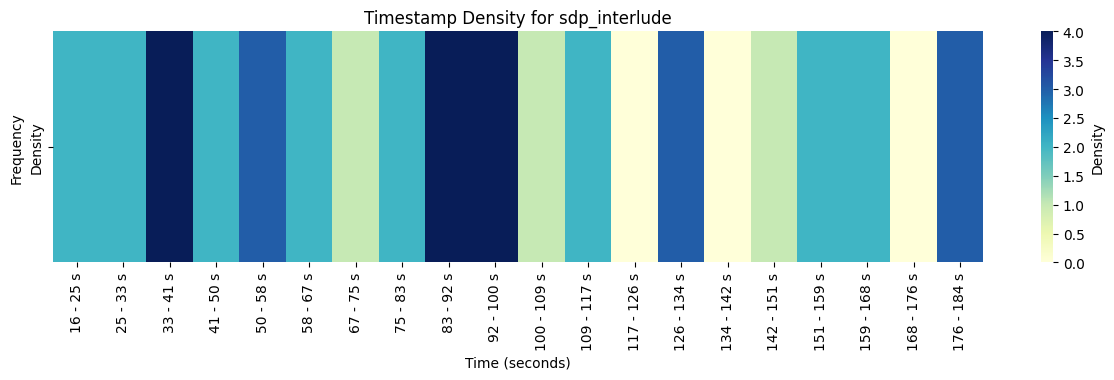

In [58]:
for test_num, pair in enumerate(timestamps_set):
    name = pair[0]
    timestamps = pair[1]
    samples_path_name = f"test{7}/slices/"
    binsize = 0
    for file_name in os.listdir(samples_path_name):
        binsize += 1
    hist_data, bins = np.histogram(timestamps, bins=binsize) # Adjust the number of bins if needed
    
    hist_data = hist_data.reshape(-1, 1) # Normalizing the hist_data for the heatmap
    print(hist_data.argmax())
    time_labels = [(f"{int(bins[i])} - {int(bins[i+1])} s") for i in range(len(bins) - 1)] # Define the time labels for the x-axis
    
    # Create a DataFrame to hold the data
    import pandas as pd
    df = pd.DataFrame(hist_data, columns=['Density'])
    # display(df)
    df.index = time_labels
    df = df.T

    # Plot the heatmap
    plt.figure(figsize=(15, 3))
    sns.heatmap(df, cmap="YlGnBu", cbar_kws={'label': 'Density'})
    plt.title(f'Timestamp Density for {name}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency')
    plt.show()  

# TODO: enable histogram search to allow highlights to be taken
# TODO: how does delete functionality work? Should be able to drop tables?
# What is the difference between the SONGS table and the FINGERPRINT table?
# TODO: what is the result of this heuristic on songs with no lyrics (e.g. metro boomin)

In [180]:
# Python 3 program to find the longest repeated
# non-overlapping substring
 
# Returns the longest repeating non-overlapping
# substring in str


def longestRepeatedSubstring(str):
 
    n = len(str)
    LCSRe = [[0 for x in range(n + 1)]
                for y in range(n + 1)]
 
    res = "" # To store result
    res_length = 0 # To store length of result
 
    # building table in bottom-up manner
    index = 0
    for i in range(1, n + 1):
        for j in range(i + 1, n + 1):
             
            # (j-i) > LCSRe[i-1][j-1] to remove
            # overlapping
            if (str[i - 1] == str[j - 1] and
                LCSRe[i - 1][j - 1] < (j - i)):
                LCSRe[i][j] = LCSRe[i - 1][j - 1] + 1
 
                # updating maximum length of the
                # substring and updating the finishing
                # index of the suffix
                if (LCSRe[i][j] > res_length):
                    res_length = LCSRe[i][j]
                    index = max(i, index)
                 
            else:
                LCSRe[i][j] = 0
 
    # If we have non-empty result, then insert
    # all characters from first character to
    # last character of string
    if (res_length > 0):
        for i in range(index - res_length + 1,
                                    index + 1):
            res = res + str[i - 1]
 
    return res

In [181]:
import ast

with open("results.txt", "r") as f:
    for string in f:
        string_representation = string

similar_sections = ast.literal_eval(string_representation)
print(sorted(similar_sections.items()))
'''for item in sorted(similar_sections.items()):
    print(item)  # Output: {'a': 1, 'b': 2, 'c': 3}'''

char = 'A'
seen = {}
reverse_search = {}
for key, _ in sorted(similar_sections.items()):
    for similar_time in similar_sections[key]:
        if similar_time in seen:
            seen[key] = seen[similar_time]
            break
    if key not in seen:
        seen[key] = char
    if seen[key] in reverse_search:
        reverse_search[seen[key]] = [key]

    char = chr(ord(char) + 1)

string = ""
for timestamp, char in sorted(seen.items()):
    string += char

suffixTree = SuffixTree(string)
chorus = suffixTree.node.getLongestRepeatedSubString()
print(f"longest overlapping chorus: {chorus}")
chorus = longestRepeatedSubstring(string) # TODO: decide between which substring algo is better
# TODO: verify with GPT whether these approaches work properly. 
print(f"longest non-overlapping chorus: {chorus}") # TODO: enable reverse search to automatically extract chorus files.


print(string)
print(sorted(seen.items()))
# TODO: what happens if beat detection doesn't work?
# Guiding principles: dig into the math, it can often give you the real-world definition for things. Things are alway smore complicated in the math. Occams razor, stick to what's simplest or easiest to implementn. Don't stack too many things -- 90 of 90 of 90 turns out more to like 70% overall accuracy. 

[(16.65, [25.55, 87.22]), (25.55, [43.34, 87.22]), (34.44, [43.34, 78.37]), (43.34, [78.37, 87.22]), (52.13, [87.22, 96.13]), (60.58, [78.37, 69.45]), (69.45, [78.37, 96.13]), (78.37, [96.13, 87.22]), (87.22, [96.13]), (96.13, []), (104.99, [16.65, 52.13]), (113.89, [25.55, 60.58]), (122.71, [34.44, 131.67]), (131.67, [34.44, 43.34]), (140.57, [149.42, 167.22]), (149.42, [184.92, 87.22]), (158.34, [184.92, 96.13]), (167.22, [184.92, 87.22]), (176.11, [87.22, 184.92]), (184.92, [96.13, 87.22])]
longest overlapping chorus: ABC
longest non-overlapping chorus: ABC
ABCDEFGHIJABCCOIJIIJ
[(16.65, 'A'), (25.55, 'B'), (34.44, 'C'), (43.34, 'D'), (52.13, 'E'), (60.58, 'F'), (69.45, 'G'), (78.37, 'H'), (87.22, 'I'), (96.13, 'J'), (104.99, 'A'), (113.89, 'B'), (122.71, 'C'), (131.67, 'C'), (140.57, 'O'), (149.42, 'I'), (158.34, 'J'), (167.22, 'I'), (176.11, 'I'), (184.92, 'J')]


In [187]:
song_path = "test_files/sdp_interlude.mp3"
song = AudioSegment.from_mp3(song_path)

start = 16.65
end = 43.34
song_slice = song[start*1000:end*1000] # pydub does things in milliseconds
song_slice.export(f"result-lcs/{song_path.split('/')[1]}_{start*1000}_{end*1000}.mp3", format="mp3")

start = 104.99
end = 131.67
song_slice = song[start*1000:end*1000] # pydub does things in milliseconds
song_slice.export(f"result-lcs/{song_path.split('/')[1]}_{start*1000}_{end*1000}.mp3", format="mp3")

<_io.BufferedRandom name='result-lcs/sdp_interlude.mp3_104990.0_131670.0.mp3'>

In [128]:
import numpy as np

# Assuming your existing dictionary is called 'chunk_dict', and its keys are integers or can be enumerated
chunks = list(similar_sections.keys())
num_chunks = len(chunks)

# Initialize a square matrix with zeros
similarity_matrix = np.zeros((num_chunks, num_chunks))

# Iterate through the dictionary and set the corresponding matrix cells to 1 if the chunks match
for i, chunk_i in enumerate(chunks):
    for chunk_j in similar_sections[chunk_i]:
        j = chunks.index(chunk_j)
        # print(f"i: {i}, chunk_i: {chunk_i}, j: {j}, chunk_j: {chunk_j}")
        if i==j:
            similarity_matrix[i, j] = 0.5
        else:
            similarity_matrix[i, j] = 1
            similarity_matrix[j, i] = 1
# The resulting similarity_matrix will have 1 where chunks match and 0 otherwise

i: 0, chunk_i: 0.04, j: 24, chunk_j: 7.83
i: 0, chunk_i: 0.04, j: 3, chunk_j: 118.24
i: 1, chunk_i: 101.0, j: 13, chunk_j: 195.95
i: 1, chunk_i: 101.0, j: 27, chunk_j: 92.58
i: 2, chunk_i: 109.57, j: 15, chunk_j: 212.94
i: 2, chunk_i: 109.57, j: 14, chunk_j: 204.45
i: 3, chunk_i: 118.24, j: 24, chunk_j: 7.83
i: 3, chunk_i: 118.24, j: 4, chunk_j: 126.92
i: 4, chunk_i: 126.92, j: 5, chunk_j: 135.89
i: 4, chunk_i: 126.92, j: 7, chunk_j: 15.77
i: 5, chunk_i: 135.89, j: 21, chunk_j: 49.06
i: 5, chunk_i: 135.89, j: 6, chunk_j: 144.39
i: 6, chunk_i: 144.39, j: 21, chunk_j: 49.06
i: 6, chunk_i: 144.39, j: 7, chunk_j: 15.77
i: 7, chunk_i: 15.77, j: 20, chunk_j: 40.52
i: 7, chunk_i: 15.77, j: 21, chunk_j: 49.06
i: 8, chunk_i: 153.18, j: 21, chunk_j: 49.06
i: 8, chunk_i: 153.18, j: 24, chunk_j: 7.83
i: 9, chunk_i: 161.91, j: 23, chunk_j: 67.11
i: 9, chunk_i: 161.91, j: 25, chunk_j: 75.4
i: 10, chunk_i: 170.53, j: 25, chunk_j: 75.4
i: 10, chunk_i: 170.53, j: 26, chunk_j: 83.93
i: 11, chunk_i: 179.

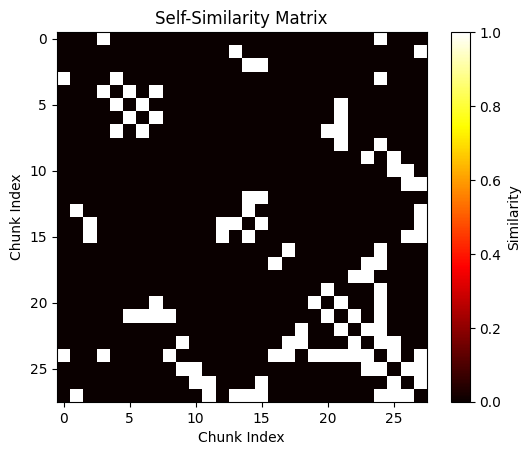

In [129]:
import matplotlib.pyplot as plt

plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.title('Self-Similarity Matrix')
plt.xlabel('Chunk Index')
plt.ylabel('Chunk Index')
plt.colorbar(label='Similarity')
plt.show()

# Shouldn't it be reflected along the x-axis? Why does the data look like this?
# TODO: I'm still unsure about whether values are properly being removed and added back into the MySQL database. 
# Is it still possible that they're not being properly re-added into the database?


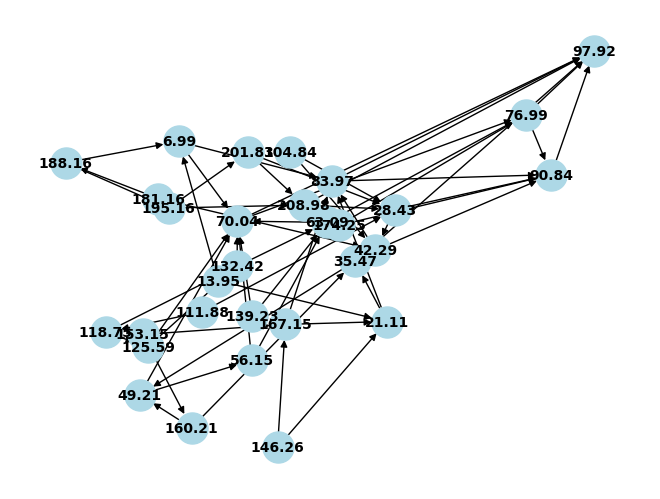

In [188]:
import networkx as nx
import matplotlib.pyplot as plt

# Your dictionary (replace with your actual data)
data_dict = {
    'a': ['b', 'c'],
    'b': ['a'],
    'c': ["c", "b"],
    'd': []
}

data_dict = dictionary

# Create a directed graph
G = nx.DiGraph()

# Add nodes from the keys
G.add_nodes_from(data_dict.keys())

# Add edges from the key-value pairs
for key, values in data_dict.items():
    for value in values:
        G.add_edge(key, value)

pos = nx.spring_layout(G, k=0.1) # You can change the value of k to adjust the spacing



# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_weight='bold', font_size=10)
plt.show()

# TODO: thought: map out all the distances between hashes, --> edge-weighted graph --> clustering 
# plotly is the best 
# kernel density estimator
# when intimidated, try creating an OOP API to formulate your thoughts. Many things work better when OOP. 
# TODO: try running on Frankie's matrix multiplication algorithm. 


In [190]:
cycles = list(nx.simple_cycles(G))
for cycle in cycles:
    print(cycle)